Troubleshooting pointcounts.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
from shapely.geometry import Polygon

In [2]:
def scopeCountsInAreas(countname, ncounts_df, area_gdf):
    # read counts per station, with point locations
    ncounts_gdf = gpd.GeoDataFrame(ncounts_df,
                                   geometry = gpd.points_from_xy(ncounts_df.stop_lon, ncounts_df.stop_lat),
                                   crs="epsg:4326").to_crs("epsg:4326")
    ## get sum of stuff in each AGS
    agg_counts_df = gpd.sjoin(area_gdf[["AGS","geometry"]], ncounts_gdf[["n_day","geometry"]], how="left", op="contains" # spatial join
                        )[["AGS","n_day"]
                        ].groupby("AGS").sum().rename({"n_day":countname},axis=1
                        ) # keep AGS that have counts in them
    return(agg_counts_df)

In [3]:
def make_grid(scale, stopspace):   
    # scale is a sidelength in km
    # stopspace is a Geodataframe containing the complex hull of the space to be covered with grid, IN EPSG:3035
    print("Making grid with sidelength "+ str(scale) + "km")
    # iterate little boxes with sidelength sl:
    bounds = stopspace.total_bounds
    xmin,ymin,xmax,ymax =  bounds
    slm = scale*1000 # m
    rows = int(np.ceil((ymax-ymin) /  slm)) 
    cols = int(np.ceil((xmax-xmin) / slm))  
    print(str(rows) + " x " + str(cols))
    XleftOrigin = xmin
    XrightOrigin = xmin + slm
    YtopOrigin = ymax
    YbottomOrigin = ymax- slm
    polygons = []
    for i in range(cols):
        Ytop = YtopOrigin
        Ybottom =YbottomOrigin
        for j in range(rows):
            polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])) 
            Ytop = Ytop - slm
            Ybottom = Ybottom - slm
        XleftOrigin = XleftOrigin + slm
        XrightOrigin = XrightOrigin + slm
    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid.crs = 'epsg:3035'
    grid = grid[~gpd.sjoin(grid, stopspace, how='left', op='intersects')["index_right"].isna()] # choose squares that overlap with convex hull
#    grids[scale] = grid                                                             # either save all the grids in a dict...    # or save them to file--if it gets big that may be better
    return(grid)

In [52]:
def aggregateGrid(grid, ncounts_gdf):
    print("Getting counts for grid with " + str(len(grid)) + " polygons")
#    agg_counts_gdf = grids[scale] # or if this gets too unwieldy load from disk...
    agg_counts_gdf = grid.to_crs('epsg:4326')
    ### !!! I'm worried we might lose shapes here, if they don't have one of the type of counts. Maybe better to keep them separate (like above)
    ## get sum of stuff in each AGS
    agg_counts_gdf = gpd.sjoin(agg_counts_gdf, ncounts_gdf[["n_day","geometry"]].to_crs('epsg:4326'), how="left", op="contains" # spatial join
                        ).drop("index_right",axis=1).reset_index().dissolve(by="index",aggfunc='sum').rename({"n_day":"n"},axis=1)
    agg_counts_gdf = agg_counts_gdf[agg_counts_gdf['n']>0]
    return(agg_counts_gdf)

In [53]:
# Welche Pfade?
out_dir = "/home/maita/Nextcloud/Documents/Work/Gap_Map/out/Delfi/"
pointfile = out_dir + "20211015_fahrplaene_gesamtdeutschland_gtfs.nstops.csv"

In [54]:

points = pd.read_csv(pointfile)

In [127]:
points_gdf = gpd.GeoDataFrame(points,
                                       geometry = gpd.points_from_xy(points.stop_lon, points.stop_lat),
                                       crs="epsg:4326").to_crs("epsg:4326")

In [128]:
points_gdf.shape

(434024, 10)

<AxesSubplot:>

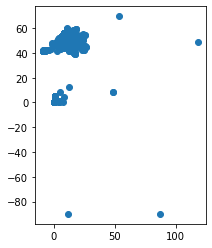

In [129]:
points_gdf.plot()

/home/maita/anaconda3/envs/gapmapbox/lib/python3.9/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

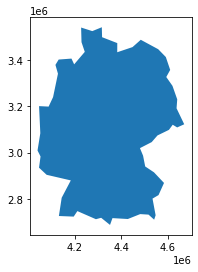

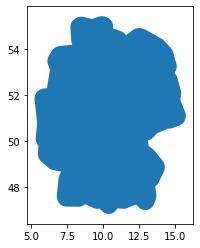

In [126]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('epsg:3035')
germany = world[world.name == "Germany"]
germany.plot()
germany['geometry'] = germany.geometry.buffer(50000)
germany = germany.to_crs('epsg:4326') #50k buffer
germany.plot()

In [130]:
points_gdf = gpd.sjoin(points_gdf, germany[['geometry']], how="inner", op="within" # spatial join
                        )

In [131]:
points_gdf.head()

,Unnamed: 0,stop_id,n,stop_name,parent_station,stop_lat,stop_lon,location_type,n_day,geometry,index_right
0,0,de:06413:8041:2:2,8853.0,Offenbach (Main)-Rumpenheim Kurhessenplatz,NaN,50.129671,8.797541,0,124.690141,POINT (8.79754 50.12967),121
1,1,de:06413:8041:1:1,8841.0,Offenbach (Main)-Rumpenheim Kurhessenplatz,NaN,50.129374,8.797052,0,124.521127,POINT (8.79705 50.12937),121
2,2,de:06412:1502:32:3,2676.0,Frankfurt (Main) Burgstraße,NaN,50.127648,8.704689,0,37.690141,POINT (8.70469 50.12765),121
3,3,de:06412:1503:3:3,2676.0,Frankfurt (Main) Prüfling,NaN,50.128372,8.706881,0,37.690141,POINT (8.70688 50.12837),121
4,4,de:06412:1503:1:1,26886.0,Frankfurt (Main) Prüfling,NaN,50.128247,8.706909,0,378.676056,POINT (8.70691 50.12825),121


In [132]:
points_gdf.shape

(433318, 11)

<AxesSubplot:>

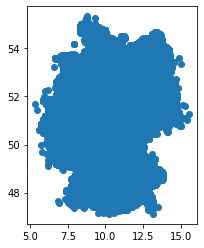

In [133]:
points_gdf.plot()

In [134]:
stopspace = gpd.GeoDataFrame({'geometry':[germany.to_crs("epsg:3035").unary_union.convex_hull]}, crs="epsg:3035")
grid_500 = make_grid(500, stopspace)
grid_50 = make_grid(50, stopspace)

grid_1 = make_grid(1, stopspace)

Making grid with sidelength 500km
2 x 2
Making grid with sidelength 50km
20 x 15
Making grid with sidelength 1km
955 x 734


### This is important! the to_crs for the counts gdf wasn' t there before, maybe that was the whole problem??

<AxesSubplot:>

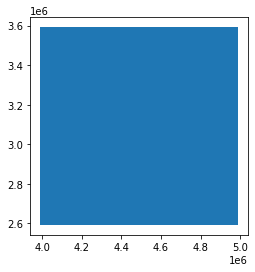

In [135]:
grid_500.plot()

In [136]:
counts_500 = aggregateGrid(grid_500, points_gdf) 

Getting counts for grid with 4 polygons


In [137]:
counts_50 = aggregateGrid(grid_50, points_gdf)

Getting counts for grid with 251 polygons


In [138]:
counts_1 = aggregateGrid(grid_1, points_gdf)

Getting counts for grid with 557373 polygons


In [139]:
points_gdf.n_day.sum()

12004861.225352112

In [140]:
counts_50.n.sum()

12004861.225352112

In [141]:
counts_500.n.sum()

12004861.225352494

In [142]:
counts_1.n.sum()

12004861.225352112

1. This works with the FV-counts from 2021 from Brosi's dataset
2. This also works with the DELFI counts, no problem!

In [83]:
gpd.read_file(out_dir + "2021_reissue_2_5k.stops.4326.geojson",driver="GeoJSON").sum(0)

index    4.670684e+08
n.all    4.130571e+09
n.fv     1.006314e+04
dtype: float64

In [84]:
gpd.read_file(out_dir + "2021_reissue_2_1k.stops.4326.geojson",driver="GeoJSON").sum(0)

index    8.530216e+10
n.all    3.474612e+08
n.fv     1.006314e+04
dtype: float64

In [ ]:
pd.read_csv(pointfile).sum(0)

What's going on with DELFI stations outside Germany?

In [88]:
points_outside_gdf = gpd.sjoin(
    gpd.GeoDataFrame(points,
                       geometry = gpd.points_from_xy(points.stop_lon, points.stop_lat),
                       crs="epsg:4326").to_crs("epsg:4326"
                        ),
                    germany[['geometry']], how="left", op="within" # spatial join
                        )

points_outside_gdf = points_outside_gdf[points_outside_gdf.index_right.isna()]

(47.0, 55.0)

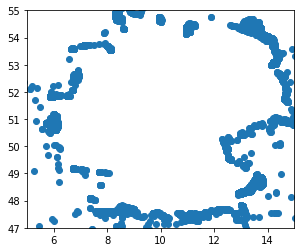

In [103]:
ax=(points_outside_gdf.plot())
ax.set_xlim([5,15])
ax.set_ylim([47,55])